## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io
import warnings

from utils.preprocessing.misc import gaussian_smoothing

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load an image with its ground truth dot annotations

In [4]:
DATASET_PATH = '../datasets/vgg_cells/train'
IMG_NAME  = '/images/007cell.png'
DOTS_NAME = '/gt_dots/007dots.png'

In [5]:
img = skimage.io.imread(f'{DATASET_PATH}/{IMG_NAME}')
dots_img = skimage.io.imread(f'{DATASET_PATH}/{DOTS_NAME}')
dots_img = dots_img.sum(axis=2) / 255.
dots_img = dots_img.astype(np.float32)

In [6]:
def desc(img, title='img: '):
    print(title, img.shape, img.min(), img.max(), img.dtype)

desc(img)
desc(dots_img, title='dots:')

img:  (256, 256, 3) 0 254 uint8
dots: (256, 256) 0.0 1.0 float32


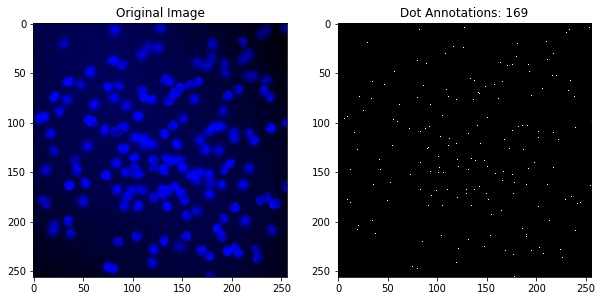

In [7]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title(f'Dot Annotations: {dots_img.sum():.0f}')
plt.imshow(dots_img, cmap='gray')
plt.show()

## 3. Create segmentation, density, count and inverse kNN maps

In [8]:
def count_map_from_dots_img(dots_img, receptive_field=32):
    num_rows, num_cols = dots_img.shape[:2]
    count_map = np.zeros((num_rows + receptive_field, num_cols + receptive_field),
                         dtype=np.float32)

    for i in range(num_rows + receptive_field):
        for j in range(num_cols + receptive_field):
            row1, col1 = max(0, i - receptive_field), max(0, j - receptive_field) 
            row2, col2 = min(num_rows, i), min(num_cols, j)
            count_map[i, j] = dots_img[row1:row2, col1:col2].sum()
        
    return count_map

In [9]:
def get_knn_dist(current_coords, label_coords):
    # k = 1
    x, y = current_coords
    dist = np.sqrt((label_coords[:, 0] - x) ** 2
                   + 
                   (label_coords[:, 1] - y) ** 2)
    return dist.min()

def iknn_map_from_dots_img(dots_img):
    label_coords = np.argwhere(dots_img == 1)
    
    num_rows, num_cols = dots_img.shape[:2]
    knn_map = np.zeros((num_rows, num_cols), dtype=np.float32)
    
    for i in range(num_rows):
        for j in range(num_cols):
            knn_map[i, j] = get_knn_dist((i, j), label_coords)
        
    return 1. / (knn_map + 1.)

In [10]:
density_map = gaussian_smoothing([dots_img], sigma=4)[0]
seg_map = (gaussian_smoothing([dots_img], sigma=2)[0] > 0.001).astype(np.int32)
count_map = count_map_from_dots_img(dots_img, receptive_field=32)
iknn_map = iknn_map_from_dots_img(dots_img)

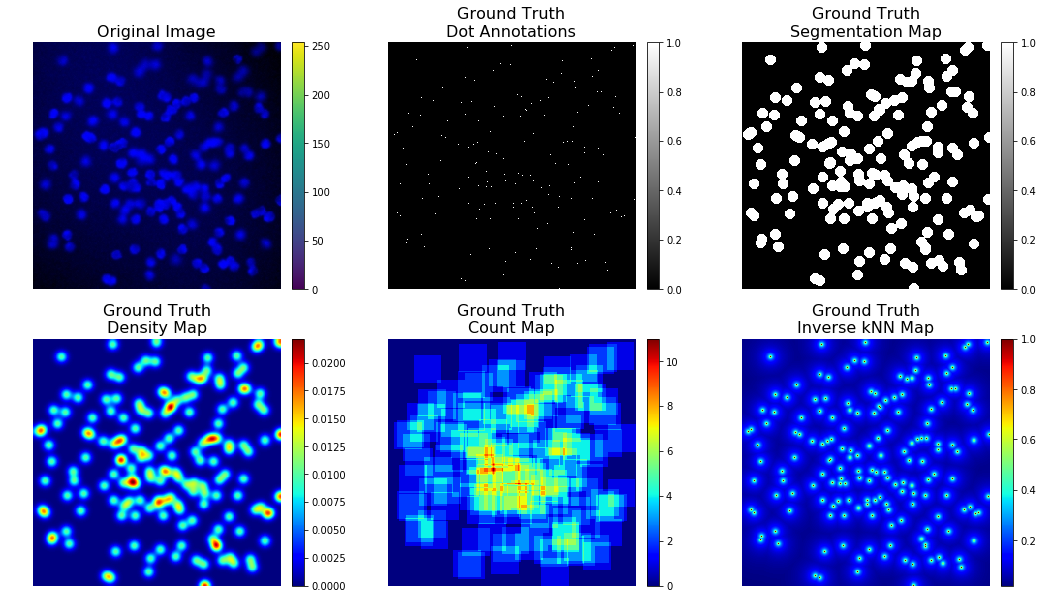

In [11]:
fontsize = 16
fraction = 0.045 
pad = 0.04

fraction=fraction
pad=pad
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.title('Original Image', fontsize=fontsize)
plt.imshow(img)
plt.colorbar(fraction=fraction, pad=pad)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Ground Truth\nDot Annotations', fontsize=fontsize)
plt.imshow(dots_img, cmap='gray')
plt.colorbar(fraction=fraction, pad=pad)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Ground Truth\nSegmentation Map', fontsize=fontsize)
plt.imshow(seg_map, cmap='gray')
plt.colorbar(fraction=fraction, pad=pad)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Ground Truth\nDensity Map', fontsize=fontsize)
plt.imshow(density_map, cmap='jet')
plt.colorbar(fraction=fraction, pad=pad)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Ground Truth\nCount Map', fontsize=fontsize)
plt.imshow(count_map, cmap='jet')
plt.colorbar(fraction=fraction, pad=pad)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Ground Truth\nInverse kNN Map', fontsize=fontsize)
plt.imshow(iknn_map, cmap='jet')
plt.colorbar(fraction=fraction, pad=pad)
plt.axis('off')

plt.show()